# Marian notebook


https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf
https://www.kaggle.com/code/junkal/selecting-the-best-regression-model



Load la data comme dans baseline


In [2]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso





from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack
import nltk# cant't find the stopword corpus otherwise
nltk.download('stopwords')
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt



# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")


# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

# You can examine the available features using X_train.head()
X_train.head()#le premier numero correspond au no de la ligne dans le csv



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
209460,sais voter veux bosser,0,40,2328,619,[],[],0,['plusjamaismacron'],1646939960000,588460
4845,gauche lolololol,0,69,2979,558,[],[],0,[],1647040875000,259731
336058,boycotte cnews comprendrons,0,2496,2992,2076,[],[],0,[],1647283863000,1051950
82060,melenchon looool,0,19194,30611,863,[],[],1,[],1647720199000,1298302
270882,mr futur président éric zemmour,0,38,701,46,[],[],0,[],1647544655000,535774


# Data cleaning


Feature selection
- mentions is always empty -> DROP Mention
- url -> can't be used as plain text -> should count the number of URLs in URLs_count
- hashtags -> first: count the number of hashtags in hashtags_count-> hashtag count is not relevant: small correlation with target + make RF score increase
            -> second: 
- remove tweetID -> TO DO

# Data processing


To do:
- data normalization
- feature extraction and selection

Contenu texte du tweet: NAN?????

In [3]:
# We set up an Tfidf Vectorizer that will use the top 100 tokens from the tweets. We also remove stopwords.
# To do that we have to fit our training dataset and then transform both the training and testing dataset. 
vectorizer = TfidfVectorizer(max_features=10, stop_words=stopwords.words('french'))
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])


# We convert the dense matrix to a dataframe
X_train_tfidf = pd.DataFrame(X_train_tfidf.todense(), columns=vectorizer.get_feature_names())
X_test_tfidf = pd.DataFrame(X_test_tfidf.todense(), columns=vectorizer.get_feature_names())

#set X_train_tfidf values as float32
X_train_tfidf = X_train_tfidf.astype('float32')
X_test_tfidf = X_test_tfidf.astype('float32')

print(X_train_tfidf.head())
print(type(X_train_tfidf))
# We add the tfidf features to our training and testing dataset
#X_train = pd.concat([X_train, X_train_tfidf], axis=1)
#X_test = pd.concat([X_test, X_test_tfidf], axis=1)

   ans  faire  france  français  gauche  macron  président   rt  vote  \
0  0.0    0.0     0.0       0.0     0.0     0.0   0.000000  0.0   0.0   
1  0.0    0.0     0.0       0.0     1.0     0.0   0.000000  0.0   0.0   
2  0.0    0.0     0.0       0.0     0.0     0.0   0.000000  0.0   0.0   
3  0.0    0.0     0.0       0.0     0.0     0.0   0.000000  0.0   0.0   
4  0.0    0.0     0.0       0.0     0.0     0.0   0.727335  0.0   0.0   

    zemmour  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.686282  
<class 'pandas.core.frame.DataFrame'>


Autres features vectorisées

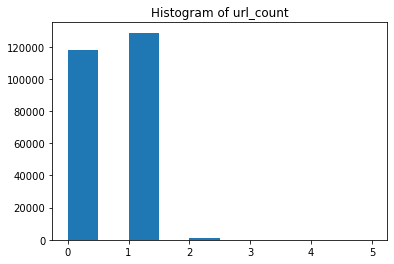

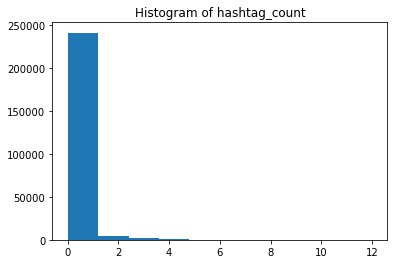

In [4]:
#mentions is always empty -> DROP Mention

X_train = X_train.drop(['mentions'], axis=1)
X_test = X_test.drop(['mentions'], axis=1)

#Tweet id is not relevant -> DROP Tweet id
X_train = X_train.drop(['TweetID'], axis=1)
X_test = X_test.drop(['TweetID'], axis=1)


#add a column to data which counts url
X_train['url_count'] = X_train['urls'].str.count('http')
X_test['url_count'] = X_test['urls'].str.count('http')
X_train = X_train.drop(['urls'], axis=1)
X_test = X_test.drop(['urls'], axis=1)
#make a visualization of url_count
plt.hist(X_train['url_count'], bins=10)
plt.title("Histogram of url_count")
plt.show()



#add a column to data which counts words in hashtags
X_train['hashtag_count'] = X_train['hashtags'].str.count(' ')
X_test['hashtag_count'] = X_test['hashtags'].str.count(' ')
X_train = X_train.drop(['hashtags'], axis=1)
X_test = X_test.drop(['hashtags'], axis=1)
#make a visualization of hashtag_count
plt.hist(X_train['hashtag_count'], bins=10)
plt.title("Histogram of hashtag_count")
plt.show()




#drop the text column
X_train = X_train.drop(['text'], axis=1)
X_test = X_test.drop(['text'], axis=1)






# Data visualization and selection

Source: https://amueller.github.io/aml/05-advanced-topics/12-feature-selection.html


### Unsupervised 

Covariance matrix

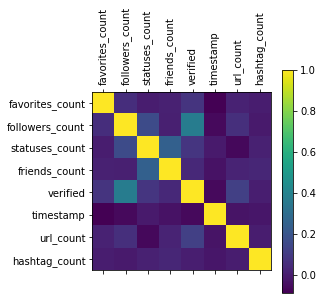

In [5]:
# plot data covariance matrix for train with features labels
cov=X_train.corr()
plt.matshow(cov)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=90)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.colorbar()
plt.show()

We can't see a single thing because it lacks clustering on the rows and columns to resort them.



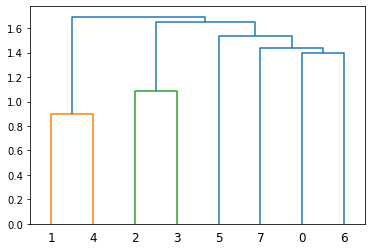

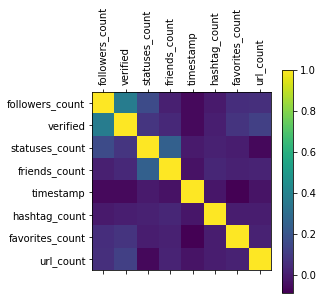

In [6]:
from scipy.cluster import hierarchy
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(cov),no_plot=False)['ivl'], dtype="int")

rearranged_cov = cov.iloc[order, order]
plt.matshow(rearranged_cov)
plt.xticks(range(len(X_train.columns)), X_train.columns[order], rotation=90)
plt.yticks(range(len(X_train.columns)), X_train.columns[order])
plt.colorbar()
plt.show()





The way you could do covariance based feature selection is you look at the features that have the highest covariance and just drop one of them 

#### Supervised 1


Correlation with target

Source: "redicting ReTweet Count Using Visual Cues"
-> We could discard features not correlated enough to reweet ie correlation <0.05

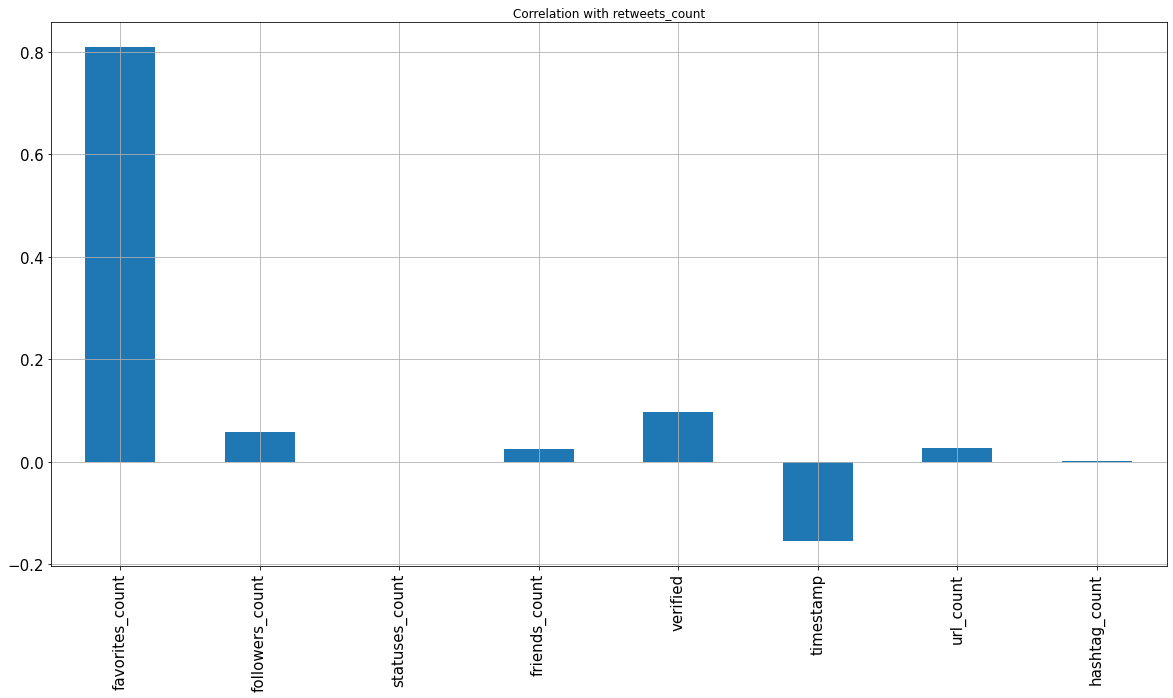

favorites_count    0.809522
followers_count    0.058069
statuses_count     0.000132
friends_count      0.024707
verified           0.097147
timestamp         -0.154733
url_count          0.026016
hashtag_count      0.000813
dtype: float64


In [7]:
#concatenate X_train and y_train
X_train.corrwith(y_train).plot.bar(
        #show exact values
        figsize = (20, 10), title = "Correlation with retweets_count", fontsize = 15,
        rot = 90, grid = True)

plt.show()

print(X_train.corrwith(y_train))



#### Supervised 2
Mutual information

Source: 
https://machinelearningmastery.com/feature-selection-for-regression-data/

In [8]:

# example of mutual information feature selection for numerical input data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot




# configure to select all features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
for i in range(len(fs.scores_)):
	#print name feature i, score
	print( X_train.columns[i], fs.scores_[i])




favorites_count 0.05138851548457435
followers_count 0.010649128058791035
statuses_count 0.007450065001324724
friends_count 0.030575314277403898
verified 0.024722849989661455
timestamp 0.013473955177126129
url_count 0.02704803616068574
hashtag_count 0.0011264967956892136


#### visualization -> Not used now

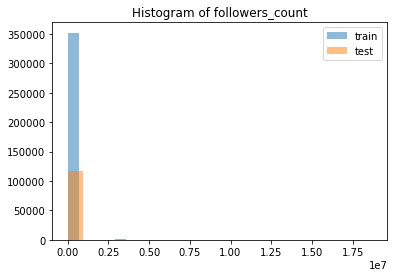

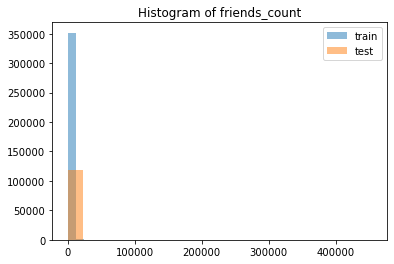

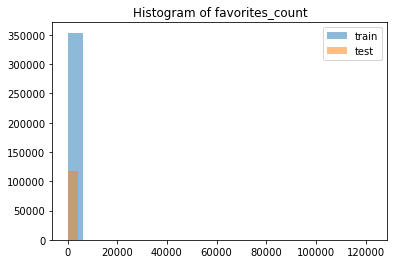

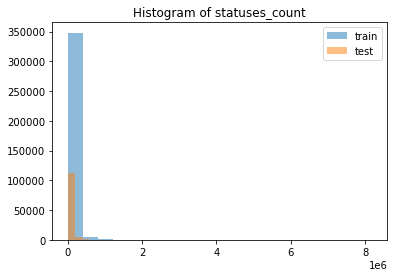

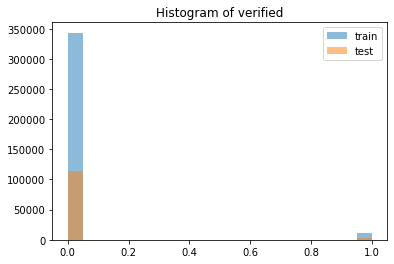

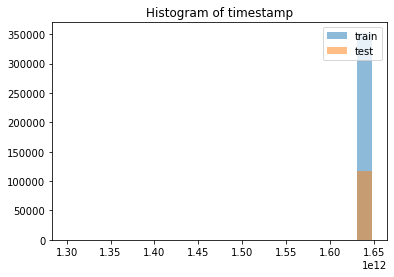

In [9]:
#visualize if features have same distribution in test and train
for col in ['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'timestamp']:

    plt.hist(train_data[col], bins=20, alpha=0.5, label='train')
    plt.hist(eval_data[col], bins=20, alpha=0.5, label='test')
    plt.title("Histogram of " + col)
    plt.legend(loc='upper right')
    #zoom on the pic of the histogram    
    plt.show()
    


# First regressors

## LASSOOOOOOOOOOO

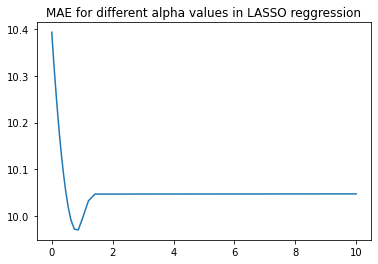

<Figure size 7200x14400 with 0 Axes>

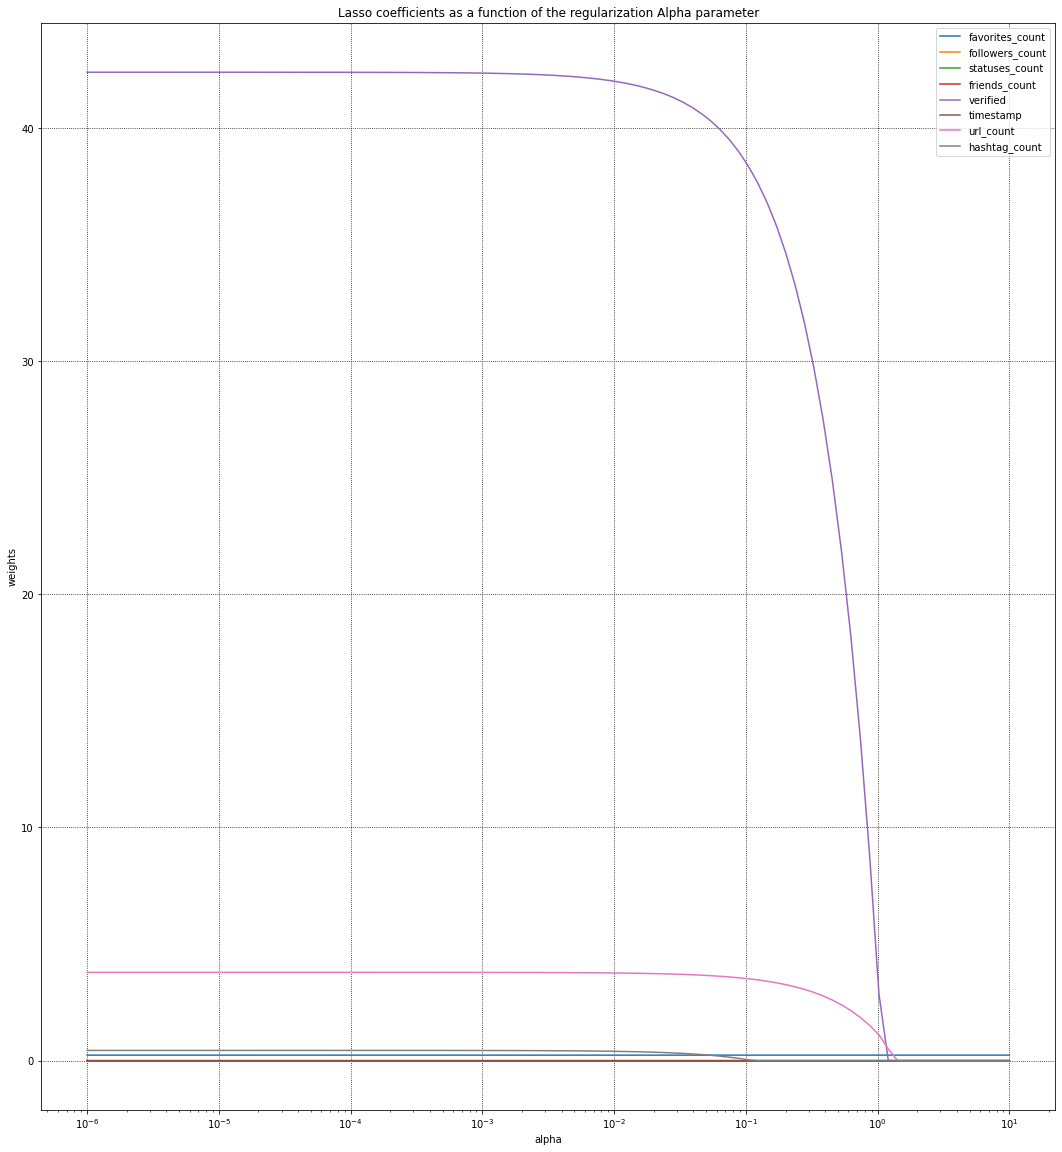

In [10]:

# Now we can train our model.  we set our loss function 

#plot linear regression result with LASSO regularization with alpha between 0 and 1
alpha = np.logspace(-6, 1, 100)
mae = []
coefs = []

for a in alpha:
    reg = Lasso(alpha=a)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mae.append(mean_absolute_error(y_test, y_pred))
    coefs.append(reg.coef_)

plt.plot(alpha, mae)
plt.title("MAE for different alpha values in LASSO reggression")
#size of the plot
plt.figure(figsize=(100,200))
plt.show()

#plot lasso coefficients for different alpha values
plt.figure(figsize=(40, 20))
plt.subplot(121)
ax = plt.gca()
ax.plot(alpha, coefs)
ax.legend(X_train.columns)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization Alpha parameter')
plt.axis('tight')
plt.grid(color='black', linestyle='dotted')
plt.show()








## RANDOM FOREEEST

source for feature selection: https://amueller.github.io/aml/05-advanced-topics/12-feature-selection.html

Feature selection  for random forest


reg2 = RandomForestRegressor() 


from sklearn.feature_selection import RFE
for i in range(1, len(X_train.columns)+1):
    select = RFE(reg2,n_features_to_select=i)
    select.fit(X_train, y_train)
    #print selected features
    print(X_train.columns[select.support_])

    #print mean absolute error
    y_pred=select.predict(X_test)
    y_pred = [int(value) if value >= 0 else 0 for value in y_pred]
    print(i,'features: Prediction error Random Forest:',mean_absolute_error(y_test, y_pred))



#20 min per features number



Index(['favorites_count'], dtype='object')
1 features: Prediction error Random Forest: 8.134917271708526

Index(['favorites_count', 'timestamp'], dtype='object')
2 features: Prediction error Random Forest: 6.82604928854611

Index(['favorites_count', 'followers_count', 'timestamp'], dtype='object')
3 features: Prediction error Random Forest: 6.569370285617425

Index(['favorites_count', 'followers_count', 'statuses_count', 'timestamp'], dtype='object')
4 features: Prediction error Random Forest: 6.490728969498357

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'timestamp'],
      dtype='object')
5 features: Prediction error Random Forest: 6.362526014445669

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'timestamp', 'url_count'],
      dtype='object')
6 features: Prediction error Random Forest: 6.212918232241904
Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'verified', 'timestamp', 'url_count'],
      dtype='object')
7 features: Prediction error Random Forest: 6.1723498224896645

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'verified', 'timestamp', 'url_count', 'hashtag_count'],
      dtype='object')
8 features: Prediction error Random Forest: 6.234285391417352

In [12]:
reg1 = GradientBoostingRegressor()


# We fit our model using the training data
reg1.fit(X_train, y_train)
# And then we predict the values for our testing set
y_pred = reg1.predict(X_test)
# We want to make sure that all predictions are non-negative integers
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]

print("Prediction error Gradient Boosting:", mean_absolute_error(y_true=y_test, y_pred=y_pred))



Prediction error Gradient Boosting: 6.496124907007185
